In [1]:
import tensorflow as tf
import modules.layers as tf_util
import modules.utility as util
import numpy as np
import tables
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

#######################################################
# Get data
#############
#CT Dataset
data_path = '/media/marsdenlab/Data2/datasets/DeepLofting/'
train = data_path+'train_192_ct.hdf5'
val = data_path+'val_192_ct.hdf5'
test = data_path+'test_192_ct.hdf5'
MODEL_CODE = 'CT'

#MR Dataset
# train = data_path+'train_192_mr.hdf5'
# val = data_path+'val_192_mr.hdf5'
# test = data_path+'test_192_mr.hdf5'
# MODEL_CODE = 'MR'

f_train = tables.open_file(train)
f_val = tables.open_file(val)

input_shape = f_train.root.X.shape
output_shape = f_train.root.Y.shape
print input_shape, output_shape

print 'data shapes, train={},{}'.format(input_shape,output_shape)
print f_val.root.X.shape

##########################################

I2IFC = True

model_path = './models/i2i_vanilla_ct/i2i_ct'
code = 'i2i'
if I2IFC:
    model_path = './models/i2i_CT/i2i_CT'
    code = 'i2ifc'

Using TensorFlow backend.


<IPython.core.display.Javascript object>

autoscrolling long output is disabled
(80004, 192, 192, 1) (80004, 192, 192, 1)
data shapes, train=(80004, 192, 192, 1),(80004, 192, 192, 1)
(4333, 192, 192, 1)


In [2]:
######################################################
# Define variables
######################################################
N = f_train.root.X.shape[0]
Nval = f_val.root.X.shape[0]
W,H,C = f_train.root.X[0].shape
C=1
crop_dims = 128
Nbatch = 16
lr = 1e-4
Nsteps=40000
print_step=200
init = 7e-2
lam = 0.0001
Nfilters = 32

EPS=1e-4
leaky_relu = tf.contrib.keras.layers.LeakyReLU(0.2)
y_index=0
alph = 0.3
beta = 0.7

In [3]:
def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
    return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x)-alpha)
with tf.device('/cpu:0'):

    #########################################################
    # Define graph
    #########################################################
    #lr_tf = tf.placeholder(shape=[],dtype=tf.float32,name='lr')
    x = tf.placeholder(shape=[None,crop_dims,crop_dims,C],dtype=tf.float32)
    y = tf.placeholder(shape=[None,crop_dims,crop_dims,C],dtype=tf.float32)

    ###############
    # I2I
    ###############

    yclass,yhat,o3,o4 = tf_util.I2INet(x,nfilters=Nfilters,activation=leaky_relu,init=init)

    if I2IFC:
        y_vec = tf.reshape(yhat, (Nbatch,crop_dims**2))

        sp = tf_util.fullyConnected(y_vec,crop_dims,leaky_relu, std='xavier', scope='sp1')
        sp = tf_util.fullyConnected(y_vec,crop_dims**2,leaky_relu, std='xavier', scope='sp2')
        sp = tf.reshape(sp, (Nbatch,crop_dims,crop_dims,1))

        y_sp = tf_util.conv2D(sp, nfilters=Nfilters, activation=leaky_relu,init=init, scope='sp3')
        y_sp_1 = tf_util.conv2D(y_sp, nfilters=Nfilters, activation=leaky_relu, init=init,scope='sp4')
        y_sp_2 = tf_util.conv2D(y_sp_1, nfilters=Nfilters, activation=leaky_relu, init=init,scope='sp5')

        yhat = tf_util.conv2D(y_sp_2, nfilters=1, activation=tf.identity, init=init,scope='sp6')

        yclass = tf.sigmoid(yhat)

    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=yhat,labels=y))

    loss = loss + tf_util.l2_reg(lam)

opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

print yclass

saver = tf.train.Saver()

[16, 16384]
[16, 16384]
Tensor("Sigmoid_1:0", shape=(16, 128, 128, 1), dtype=float32, device=/device:CPU:0)


In [4]:
saver.restore(sess,model_path)

INFO:tensorflow:Restoring parameters from ./models/i2i_CT/i2i_CT


(1, 128, 128, 1)


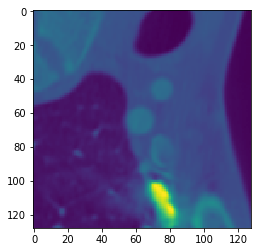

In [5]:
img = f_val.root.X[100][:,:,0]
img = util.crop_center(img,crop_dims,crop_dims).reshape((1,crop_dims,crop_dims,C))
print img.shape
plt.figure()
plt.imshow(img[0,:,:,0])
plt.show()

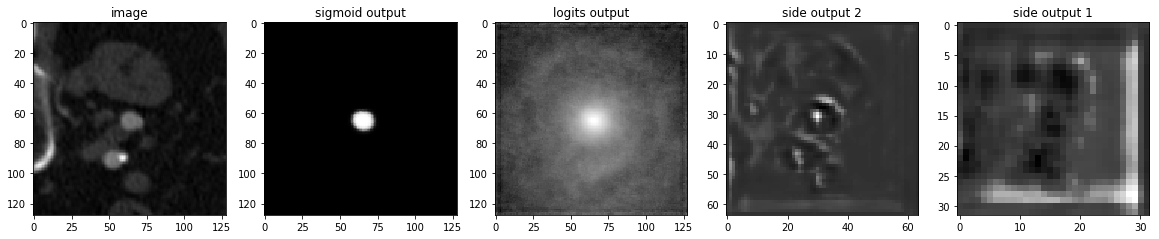

In [11]:
j = np.random.randint(Nval-Nbatch)
img = f_val.root.X[j:j+Nbatch]
img = util.crop_center_nd(img,crop_dims,crop_dims)

ypred,ylog,side2,side1 = sess.run([yclass,yhat,o3,o4],{x:img})

fig, (ax5, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20,4))

ax5.imshow(img[0,:,:,0],cmap='gray')
ax5.set_title('image')

ax1.imshow(ypred[0,:,:,0],cmap='gray')
ax1.set_title('sigmoid output')

ax2.imshow(ylog[0,:,:,0],cmap='gray')
ax2.set_title('logits output')

ax3.imshow(side2[0,:,:,0],cmap='gray')
ax3.set_title('side output 2')

ax4.imshow(side1[0,:,:,0],cmap='gray')
ax4.set_title('side output 1')
plt.tight_layout
plt.savefig('../images/side_outputs_{}_{}.png'.format(code,j),dpi=500)
plt.show()
plt.close()